In [213]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
RANDOM_SEED = 81425

# Loading data

In [214]:
X_data = pd.read_csv('data/train_data.csv')
X_data_ktest = pd.read_csv('data/test_data.csv')
y_data = pd.read_csv('data/train_target.csv', header=-1, names=['agreed'])

In [215]:
print('Is everything ok?: ',  X_data.shape[0] == y_data.shape[0])
print('And duplicates?: ',  np.all(X_data.duplicated() == False))

Is everything ok?:  True
And duplicates?:  False


Checking if balanced sample:


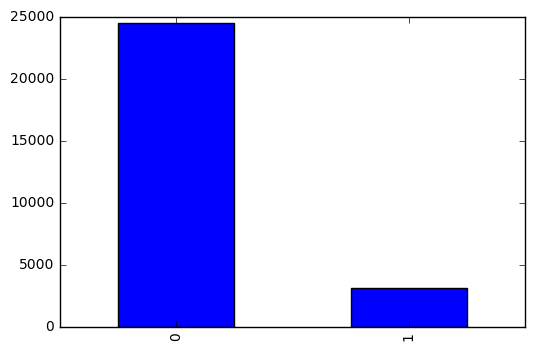

In [216]:
print('Checking if balanced sample:')
y_data['agreed'].value_counts().plot(kind='bar');

# Working with features

In [217]:
from sklearn.preprocessing import MinMaxScaler

In [218]:
X_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.00000
mean,40.085994,258.874542,2.568328,962.693169,0.172024,0.087211,93.577443,-40.503026,3.628844,5167.31696
std,10.480548,260.511236,2.765561,186.371948,0.492548,1.567343,0.578193,4.616641,1.730084,72.22960
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.60000
25%,32.000000,101.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.10000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.00000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.10000
max,94.000000,4199.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.10000


In [219]:
def convert_features(data):
    conv_data = data.copy()
    
    conv_data['default'] = conv_data.apply(lambda row: 1 if row['default'] == 'yes' else 0, axis=1)
    
    conv_data['housing'] = conv_data.apply(lambda row: 1 if row['housing'] == 'yes' else 0, axis=1)
    
    conv_data['loan'] = conv_data.apply(lambda row: 1 if row['loan'] == 'yes' else 0, axis=1)
    
    
    # nominal values
    nom_df = conv_data[['poutcome', 'month', 'day_of_week', 'education', 'marital', 'job']]
    conv_data = conv_data.drop(nom_df.columns, axis=1)
    nom_df = pd.get_dummies(nom_df)
    conv_data = pd.concat([conv_data, nom_df], axis = 1)
    
    conv_data = conv_data.drop(['previous', 'contact'], axis = 1)
    
    return conv_data

In [220]:
X_data = convert_features(X_data)

# Undersampling major feature

In [221]:
from imblearn.under_sampling import RandomUnderSampler

In [222]:
X_cols = X_data.columns
rus = RandomUnderSampler(random_state=RANDOM_SEED)
# X_data, y_data = rus.fit_sample(X_data, y_data['agreed'].values.ravel())

In [223]:
X_data = pd.DataFrame(X_data)
X_data.columns = X_cols
y_data = pd.DataFrame(y_data)
y_data.columns = ['agreed']

In [224]:
X_data.shape

(27595, 54)

# And updating test sample

In [225]:
X_data_ktest = convert_features(X_data_ktest)

# Plot with all features

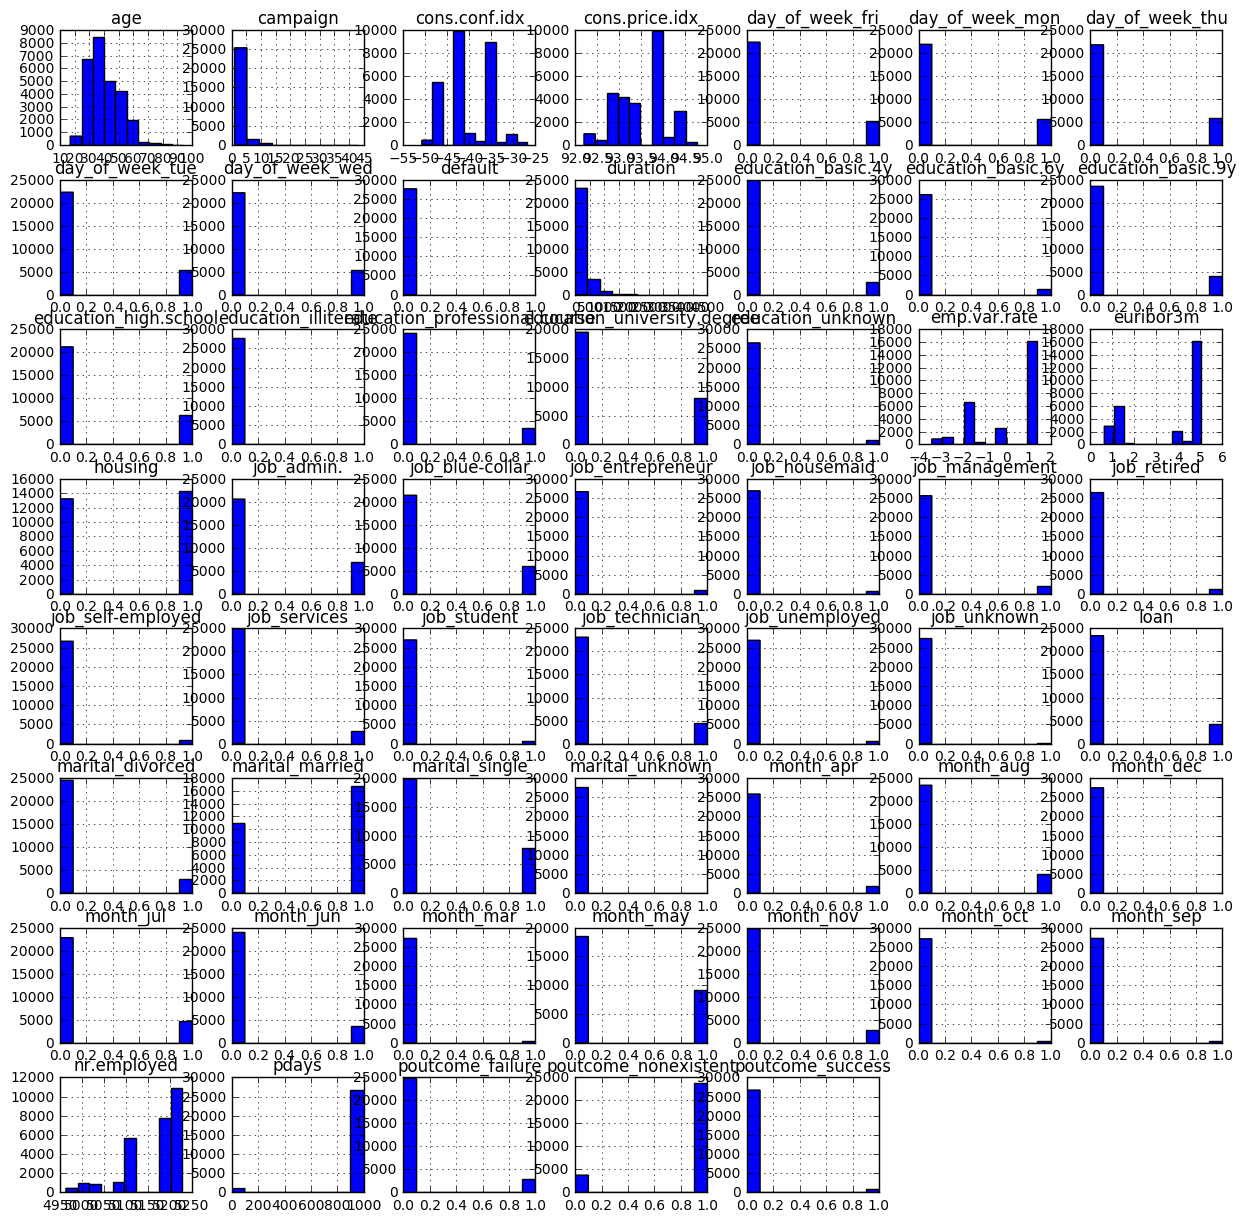

In [226]:
X_data.hist(figsize=(15, 15));

# Splitting data into train/test sets

In [227]:
from sklearn.model_selection import train_test_split

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data['agreed'].values, test_size=0.25, 
                 random_state = RANDOM_SEED, stratify=y_data['agreed'].values)

# Fitting models

In [229]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [230]:
def top_importance_print(n, importances, importances_names):
    indexes = importances.argsort()[-n:][::-1]
    for i, index in enumerate(indexes):
        print ('#{} Important feature is -- {} with {:.2f} importance'.format(i + 1, importances_names[index], importances[index]))

In [231]:
def write_to_submission_file(predicted_labels, out_file='output.csv',
                             target='Prediction', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [232]:
class ModelTester():
    def __init__(self, parameters, model, scoring='roc_auc', njobs=-1, cv=3):
        self.cv = GridSearchCV(model, parameters, scoring = scoring, n_jobs = njobs, cv = cv, verbose = 1)
    
    def test_model(self):
        self.cv.fit(X_train, y_train);
        print('Best score cv: ', self.cv.best_score_)
        print('Params: ', self.cv.best_params_)
    
        y_predicted = self.cv.predict_proba(X_test)
        print('Score on test sample:', roc_auc_score(y_test, y_predicted[:, 1]))
        
    def best_estimator(self):
        return self.cv.best_estimator_
    

## Random Forest

In [182]:
from sklearn.ensemble import RandomForestClassifier

In [183]:
param = {'criterion':['gini', 'entropy'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced', None]}

mt = ModelTester(parameters = param, model = RandomForestClassifier(random_state=RANDOM_SEED))
mt.test_model()
rf_clf = mt.best_estimator()

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s


Best score cv:  0.931252807797
Params:  {'max_depth': 32, 'max_features': 'auto', 'criterion': 'gini', 'class_weight': 'balanced'}
Score on test sample: 0.928504014441


[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   13.3s finished


## SVC

In [184]:
from sklearn.svm import SVC

In [185]:
param = {'C': np.linspace(0.01, 0.03, num=5), 
              'class_weight':['balanced', None], 'kernel':['linear'],
              'decision_function_shape' : ['ovo', 'ovr', None]}

mt = ModelTester(parameters = param, model = SVC(random_state=RANDOM_SEED, probability=True))
mt.test_model()
svc_clf = mt.best_estimator()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 16.4min finished


Best score cv:  0.936671252271
Params:  {'C': 0.01, 'decision_function_shape': 'ovo', 'kernel': 'linear', 'class_weight': None}
Score on test sample: 0.938441941584


## AdaBoostClassifier

In [186]:
from sklearn.ensemble import AdaBoostClassifier

In [187]:
param = {'algorithm': ['SAMME.R', 'SAMME'], 'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0]}

mt = ModelTester(parameters = param, model = AdaBoostClassifier(random_state=RANDOM_SEED))
mt.test_model()
adc_clf = mt.best_estimator()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Best score cv:  0.937799863805
Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.3}
Score on test sample: 0.93928261465


## DecisionTreeClassifier

In [188]:
from sklearn.tree import DecisionTreeClassifier

In [189]:
param = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 
         'class_weight' : ['balanced'], 'random_state':[RANDOM_SEED], 'presort':[True, False]}

mt = ModelTester(parameters = param, model = DecisionTreeClassifier(random_state=RANDOM_SEED))
mt.test_model()
dtc_clf = mt.best_estimator()

Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best score cv:  0.820810738179
Params:  {'random_state': 81425, 'presort': True, 'splitter': 'best', 'criterion': 'entropy', 'max_features': 'auto', 'class_weight': 'balanced'}
Score on test sample: 0.813736878405


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    1.7s finished


# KNeighborsClassifier

In [190]:
from sklearn.neighbors import KNeighborsClassifier

In [191]:
param = {'n_neighbors': [30, 50, 65, 70], 'weights': ['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
         'leaf_size' : [10, 15, 20], 'p':[1, 2]}

mt = ModelTester(parameters = param, model = KNeighborsClassifier())
mt.test_model()
knn_clf = mt.best_estimator()

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  3.0min finished


Best score cv:  0.938040474475
Params:  {'algorithm': 'auto', 'p': 1, 'leaf_size': 15, 'weights': 'distance', 'n_neighbors': 70}
Score on test sample: 0.947542495652


In [193]:
y_predicted = knn_clf.predict_proba(X_data_ktest)
write_to_submission_file(y_predicted[:, 1])

# GradientBoostingClassifier

In [194]:
from sklearn.ensemble import GradientBoostingClassifier

In [195]:
param = {'loss': ['deviance', 'exponential'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 'presort':[True, False],
         'n_estimators':[200, 300], 'min_samples_leaf' : [3]}

mt = ModelTester(parameters = param, model = GradientBoostingClassifier(random_state=RANDOM_SEED))
mt.test_model()
gbc_clf = mt.best_estimator()

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   57.4s finished


Best score cv:  0.94652085428
Params:  {'presort': False, 'loss': 'exponential', 'max_features': 'auto', 'n_estimators': 200, 'min_samples_leaf': 3}
Score on test sample: 0.953478357


# XGBoost (full train sample - better score) -- submitted to kaggle

In [233]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import math

In [234]:
param = {'max_depth': range(2, 10), 'n_estimators': [2, 4, 5, 6, 25, 35, 50, 150], 'objective' : 
         ['reg:linear', 'binary:logistic', 'binary:logitraw', 'rank:pairwise'],
         'gamma': [0, .2, .4]}

mt = ModelTester(parameters = param, model = XGBClassifier(seed=RANDOM_SEED, reg_alpha=0.005, reg_lambda=0.004))
mt.test_model()
xgb_clf = mt.best_estimator()

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed: 22.3min finished


Best score cv:  0.947509739048
Params:  {'max_depth': 4, 'n_estimators': 150, 'objective': 'binary:logistic', 'gamma': 0}
Score on test sample: 0.94435477443


In [235]:
y_predicted = xgb_clf.predict_proba(X_data_ktest)
write_to_submission_file(y_predicted[:, 1])

# VotingClassifier

In [196]:
from sklearn.ensemble import VotingClassifier

In [197]:
eclf = VotingClassifier(estimators=[('rf', rf_clf), ('knn', knn_clf)], voting='soft')
eclf.fit(X_train, y_train);

In [199]:
y_predicted = eclf.predict(X_test)
print('Score on test sample:', roc_auc_score(y_test, y_predicted))

Score on test sample: 0.885707237873
